In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import sys
sys.path.append("../")

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tueplots import bundles

from configs.configs import get_quadratic_brownian_config
from src.data.synthetic import Quadratic
from src.models.diffusion.diffuser import Diffuser1D
from src.models.diffusion.sde import SDE
from src.utils.trainer import TrainerModule, Model
from src.utils.plotting import plot_trajectories

LOAD_PATH = "../results/quadratic_brownian_g2score/"

2024-05-21 21:30:31.443885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 21:30:31.444032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 21:30:31.516575: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 21:30:33.143827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Some plot settings for NeuraIPS
plt.rcParams.update(
    bundles.neurips2024(
        family="sans-serif",
        usetex=False,
    ))
# update the tick font size
plt.rcParams.update({"xtick.labelsize": 14, "ytick.labelsize": 14})
# update the label font size
plt.rcParams.update({"axes.labelsize": 16})
cmap = colormaps.get_cmap("RdYlBu")
colors = cmap(jnp.linspace(0, 1, 200))
start_color, end_color = colors[0], colors[-1]

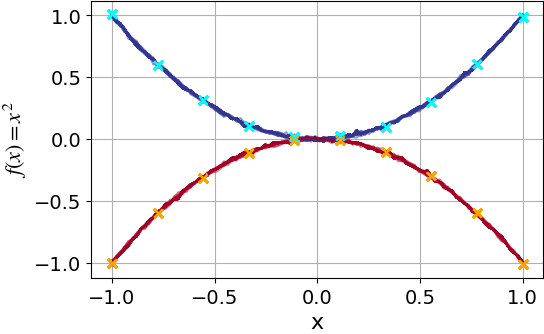

In [3]:
# Visualize the quadratic functions
X0 = Quadratic(a=1.0, shift=0.0, eps=0.01)
XT = Quadratic(a=-1.0, shift=0.0, eps=0.01)

N = 10
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, 2*N)
x = jnp.linspace(-1., 1., 100)
x_ = jnp.linspace(-1., 1., 10)

n_samples = 100
quadratic_pos = jax.vmap(X0.sample, in_axes=(None, 0))(n_samples, rng_keys[:N])
quadratic_neg = jax.vmap(XT.sample, in_axes=(None, 0))(n_samples, rng_keys[N:])

quadratic_pos_sampled = X0.sample(10, rng_keys[0])
quadratic_neg_sampled = XT.sample(10, rng_keys[-1])

fig, ax = plt.subplots()
for i in range(n_samples):
    ax.plot(x, quadratic_pos[i], color=end_color, alpha=0.5)
    ax.plot(x, quadratic_neg[i], color=start_color, alpha=0.5)
    ax.scatter(x_, quadratic_pos_sampled, color="#00FFFF", alpha=1.0, marker="x", zorder=2)
    ax.scatter(x_, quadratic_neg_sampled, color="#FFA500", alpha=1.0, marker="x", zorder=2)
ax.set_xlabel("x")
ax.set_ylabel(r"$f(x)=x^2$")
ax.grid(True)
fig.savefig("../assets/quadratic_functions.pdf", bbox_inches="tight", dpi=150)

In [4]:
# Simluate the ground truth bridge
config = get_quadratic_brownian_config()
config.training.dir = LOAD_PATH
config.sde.X0 = X0
sde = SDE(**config.sde)

class TrueModel(Model):
    def __call__(self, t: float, x: jnp.ndarray) -> jnp.ndarray:
        return -x/t

trainer = TrainerModule(config)
true_model = TrueModel(trainer)
true_diffuser = Diffuser1D(config.training.seed, sde=sde)

In [5]:
n_eval_pts = 128
x_eval = jnp.linspace(-1., 1., n_eval_pts)

y0 = (XT.sample(n_eval_pts, rng_keys[-1]) - X0.sample(n_eval_pts, rng_keys[0])).flatten()
ts = jnp.linspace(0.0, 1.0, 200)
ys = true_diffuser.solve_reverse_bridge_sde(rng_key=rng_keys[0], x0=y0, ts=ts, model=true_model)

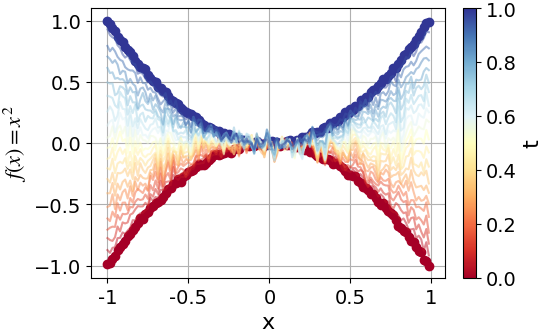

In [6]:
ys = ys.reshape((len(ts), n_eval_pts, 1))
fig, ax = plt.subplots()
plot_trajectories(dim=1, 
                  ax=ax, 
                  traj=ys+X0.sample(n_eval_pts, rng_keys[0])[None, ...], 
                  target=None,
                  cmap_name="RdYlBu",
                  plot_every=10)
ax.set_xlabel("x")
ax.set_ylabel(r"$f(x)=x^2$")
ax.set_xticks([0, 32, 64, 96, 128])
ax.set_xticklabels([-1, -0.5, 0, 0.5, 1])
ax.grid(True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("t")
fig.savefig("../assets/quadratic_true_brownian_bridge.pdf", bbox_inches="tight", dpi=150)

In [7]:
# Simulate the estimated bridge
trainer.train_model(pretrained=True)
est_model = Model(trainer)
est_diffuser = Diffuser1D(config.training.seed, sde=sde)

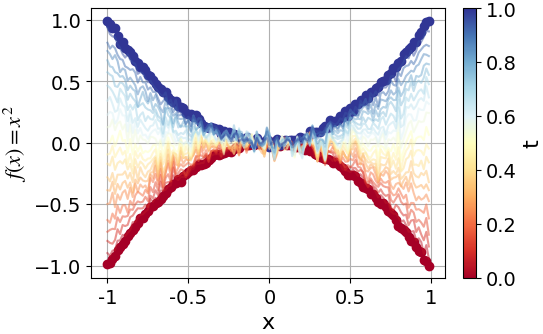

In [8]:
ys_est = est_diffuser.solve_reverse_bridge_sde(rng_key=rng_keys[0], x0=y0, ts=ts, model=est_model)
ys_est = ys_est.reshape((len(ts), n_eval_pts, 1))
fig, ax = plt.subplots()
plot_trajectories(dim=1, 
                  ax=ax, 
                  traj=ys_est+X0.sample(n_eval_pts, rng_keys[0])[None, ...], 
                  target=None,
                  cmap_name="RdYlBu",
                  plot_every=10)
ax.set_xlabel("x")
ax.set_ylabel(r"$f(x)=x^2$")
ax.set_xticks([0, 32, 64, 96, 128])
ax.set_xticklabels([-1, -0.5, 0, 0.5, 1])
ax.grid(True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("t")
fig.savefig("../assets/quadratic_estimated_brownian_bridge.pdf", bbox_inches="tight", dpi=150)

In [9]:
# Discretization invariant
n_sim = 32
ts = jnp.linspace(0.0, 1.0, 50)
rng_keys = jax.random.split(rng_key, n_sim)

In [10]:
# evaluate at 8 points
n_eval_pts = 8
y0 = (XT.sample(n_eval_pts, rng_keys[-1]) - X0.sample(n_eval_pts, rng_keys[0])).flatten()
yss_true = jax.vmap(lambda rng_key: true_diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=true_model))(rng_keys)
yss_est = jax.vmap(lambda rng_key: est_diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=est_model))(rng_keys)
mse_8 = jnp.mean((yss_true - yss_est)**2)

In [11]:
# evaluate at 16 points
n_eval_pts = 16
y0 = (XT.sample(n_eval_pts, rng_keys[-1]) - X0.sample(n_eval_pts, rng_keys[0])).flatten()
yss_true = jax.vmap(lambda rng_key: true_diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=true_model))(rng_keys)
yss_est = jax.vmap(lambda rng_key: est_diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=est_model))(rng_keys)
mse_16 = jnp.mean((yss_true - yss_est)**2)

In [12]:
# evaluate at 32 points
n_eval_pts = 32
y0 = (XT.sample(n_eval_pts, rng_keys[-1]) - X0.sample(n_eval_pts, rng_keys[0])).flatten()
yss_true = jax.vmap(lambda rng_key: true_diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=true_model))(rng_keys)
yss_est = jax.vmap(lambda rng_key: est_diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=est_model))(rng_keys)
mse_32 = jnp.mean((yss_true - yss_est)**2)

In [13]:
# evaluate at 64 points
n_eval_pts = 64
y0 = (XT.sample(n_eval_pts, rng_keys[-1]) - X0.sample(n_eval_pts, rng_keys[0])).flatten()
yss_true = jax.vmap(lambda rng_key: true_diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=true_model))(rng_keys)
yss_est = jax.vmap(lambda rng_key: est_diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=est_model))(rng_keys)
mse_64 = jnp.mean((yss_true - yss_est)**2)

In [14]:
# evaluate at 128 points
n_eval_pts = 128
y0 = (XT.sample(n_eval_pts, rng_keys[-1]) - X0.sample(n_eval_pts, rng_keys[0])).flatten()
yss_true = jax.vmap(lambda rng_key: true_diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=true_model))(rng_keys)
yss_est = jax.vmap(lambda rng_key: est_diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=est_model))(rng_keys)
mse_128 = jnp.mean((yss_true - yss_est)**2)

In [15]:
# evaluate at 256 points
n_eval_pts = 256
y0 = (XT.sample(n_eval_pts, rng_keys[-1]) - X0.sample(n_eval_pts, rng_keys[0])).flatten()
yss_true = jax.vmap(lambda rng_key: true_diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=true_model))(rng_keys)
yss_est = jax.vmap(lambda rng_key: est_diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=est_model))(rng_keys)
mse_256 = jnp.mean((yss_true - yss_est)**2)

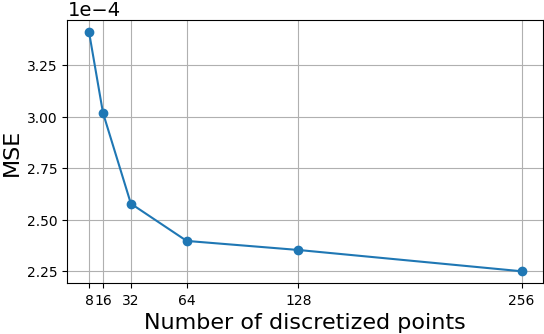

In [20]:
fig, ax = plt.subplots()
ax.plot([8, 16, 32, 64, 128, 256], [mse_8, mse_16, mse_32, mse_64, mse_128, mse_256], marker="o")
ax.set_xlabel("Number of discretized points")
ax.set_ylabel("MSE")
ax.set_xticks([8, 16, 32, 64, 128, 256])
# set x ticks font size to 14
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# set y ticks format to be in scientific notation
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
ax.grid(True)
fig.savefig("../assets/quadratic_discretization_invariant.pdf", bbox_inches="tight", dpi=150)

In [25]:
# More samples
n_sim = 8
ts = jnp.linspace(0.0, 1.0, 50)
rng_keys = jax.random.split(rng_key, n_sim*2)
n_eval_pts = 128
y0s = jax.vmap(lambda key1, key2: (XT.sample(n_eval_pts, key1) - X0.sample(n_eval_pts, key2)).flatten())(rng_keys[n_sim:], rng_keys[:n_sim])
yss_est = jax.vmap(lambda rng_key, y0: est_diffuser.solve_reverse_bridge_sde(rng_key=rng_key, x0=y0, ts=ts, model=est_model))(rng_keys[n_sim:], y0s)

In [27]:
yss_est.shape

(8, 50, 128)

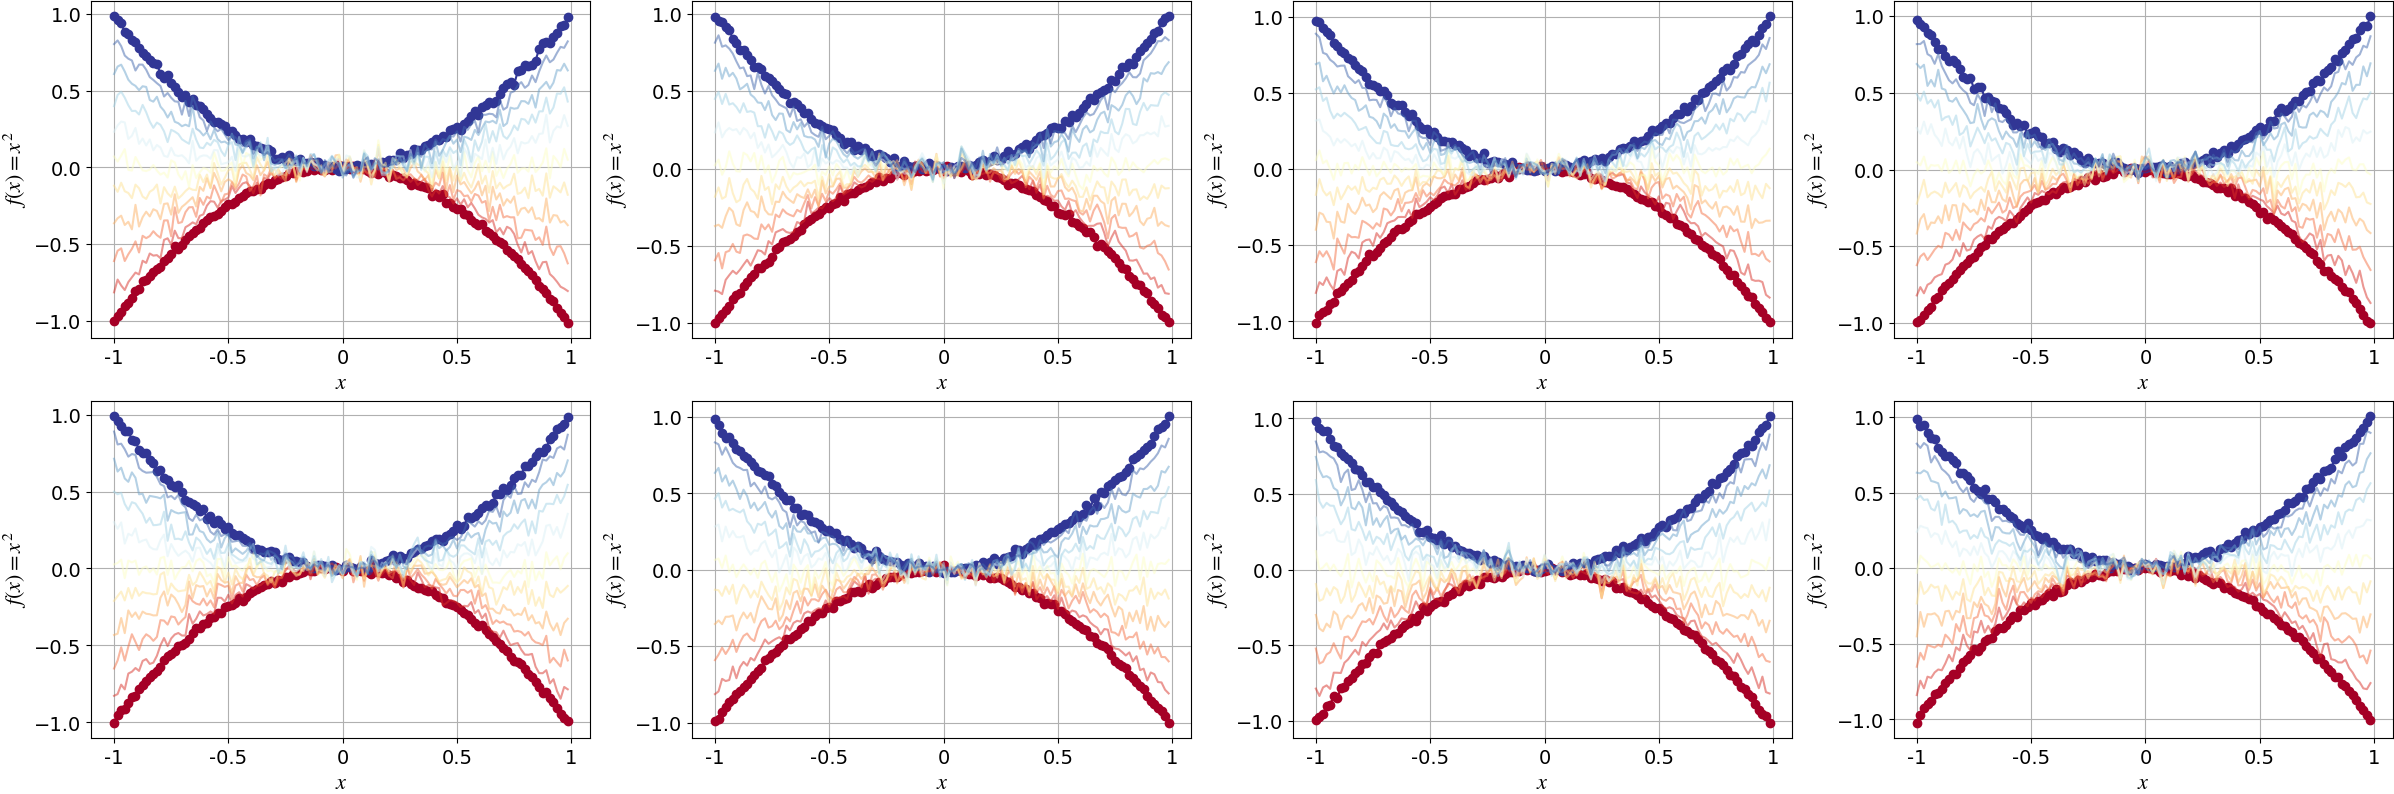

In [35]:
fig, ax = plt.subplots(2, 4, figsize=(24, 8))
ax = ax.flatten()
for i in range(8):
    yss = yss_est[i].reshape((len(ts), n_eval_pts, 1))
    plot_trajectories(dim=1, 
                      ax=ax[i], 
                      traj=yss+X0.sample(n_eval_pts, rng_keys[i])[None, ...], 
                      target=None,
                      cmap_name="RdYlBu",
                      plot_every=5)
    ax[i].set_xticks([0, 32, 64, 96, 128])
    ax[i].set_xticklabels([-1, -0.5, 0, 0.5, 1])
    ax[i].grid(True)
    ax[i].set_xlabel(r"$x$")
    ax[i].set_ylabel(r"$f(x)=x^2$")
fig.savefig("../assets/quadratic_estimated_brownian_bridge_samples.pdf", bbox_inches="tight", dpi=150)